# A Momentum Trading Strategy
##### Here I present a momentum trading strategy applied on the consituents of the S&P500 to investigate if I could have overperformed the SPY index by going long previous overperformers and going short previous underperfomers.

#### The methodology applied is the following:
* I first do some web scraping on [this](https://en.wikipedia.org/wiki/List_of_S%26P_500_companies) Wikipedia site to get the tickers of the S&P500 constituents.
* Second, I download historic price data from Yahoo Fianance for each of the S&P500 constituents.
* Third I stand at time t-1 to rank the securities based on a rolling average of their returns over the period [t-14;t-2).
* Finally, I short the worst 10% securities and allocate those funds on an equal-weights basis to go long the top 10%.

#### The result is a long/short or zero-cost portfolio that is rebalanced on a monthly basis

In [2]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import datetime as dt
from datetime import timedelta
import os

t = 12 # Number of months to calcualte the rolling average
pctg_trade = 0.1 # Percentage of tickers that we are going to trade from both ends of the monthly ranking
lag = 2 # The trade will be executed on the 2nd period after the rolling average has been calculated.
start = dt.datetime(2010,1,1)
end = dt.datetime.today() - timedelta(1) # Yesterday

In [6]:
def get_data():
    count = 1

    wiki_data = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    df_wiki = wiki_data[0]
    tickers = df_wiki['Symbol'].str.replace('.','-')

    if not os.path.exists('sp500_tickers'):
        os.makedirs('sp500_tickers')

    for ticker in tickers:
        if not os.path.exists('sp500_tickers/{}.csv'.format(ticker)):
            df_aux = web.DataReader(ticker,'yahoo',start,end)
            df_aux.to_csv('sp500_tickers/{}.csv'.format(ticker))
            print('{}: Data of ticker: {} was downloaded      '.format(count, ticker), end = '\r')
        else:
            df_existing = pd.read_csv('sp500_tickers/{}.csv'.format(ticker), parse_dates = True, index_col = 0)

            if (df_existing.index[0] > start - timedelta(5) and df_existing.index[0] < start + timedelta(5)) and (df_existing.index[-1] > end - timedelta(5) and df_existing.index[-1] < end + timedelta(5)):
                print('{}: Data of ticker: {} already downloaded      '.format(count, ticker), end = '\r')
            else:
                os.remove('sp500_tickers/{}.csv'.format(ticker))
                df_aux = web.DataReader(ticker,'yahoo',start,end)
                df_aux.to_csv('sp500_tickers/{}.csv'.format(ticker))
                print('{}: Data of ticker: {} was updated         '.format(count, ticker), end = '\r')

        count += 1

    print('')
    return tickers

tickers = get_data()

In [10]:
df_AdjClose = pd.DataFrame()
df_Vol = pd.DataFrame()
df_Returns = pd.DataFrame()

for ticker in tickers:
    df_aux = pd.read_csv('sp500_tickers/{}.csv'.format(ticker), parse_dates = True, index_col = 0)
    df_AdjClose[ticker] = df_aux['Adj Close'].resample('M', convention = 'end').pad()
    df_Vol[ticker] = df_aux['Volume'].resample('M').sum()
    
df_Returns = pd.DataFrame()

for column in df_AdjClose:
    df_Returns[column] = np.log(df_AdjClose[column]/df_AdjClose[column].shift(1))

C:\Users\fecob\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log
  del sys.path[0]


#### Note: An important consideration to have in mind when analysing this strategy is that I am introducing a survivorship bias. By running the analysis on the current S&P500 constituents, I am doing it only with those that are currently in the index. The graph below shows that, from the current 505 tickers in the S&P500 today, slightly less than 460 were part of it back in 2010. A way to avoid this effect is to include the historic composition of the index, but for now that is too complex for me to code. Hopefully, I'll be able to correct it in the near future.

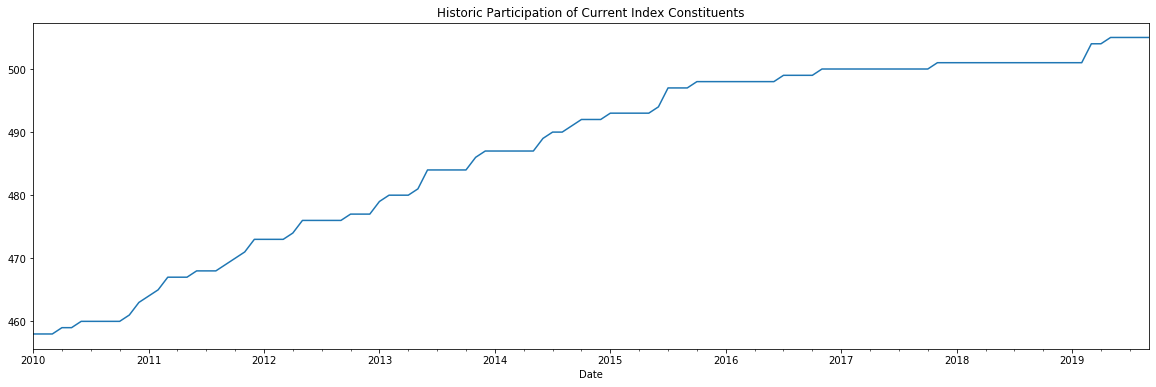

In [22]:
df_tickerCount = df_AdjClose.count(axis = 1)

df_tickerCount.plot(figsize = (20,6), title = 'Historic Participation of Current Index Constituents')

In [13]:
df_rollingReturns = pd.DataFrame()

for column in df_Returns:
    df_rollingReturns[column] = df_Returns[column].rolling(t).mean()

In [14]:
df_rank = pd.DataFrame()

df_rank = df_rollingReturns.rank(axis = 1, ascending = False)
df_rank.dropna(how = 'all', inplace = True)

In [15]:
q_tickers = pd.DataFrame()

q_tickers['q_tickers'] = df_rank.count(axis = 1)

q_tickers['goLong_cutoff'] = q_tickers['q_tickers'] * pctg_trade
q_tickers['goLong_cutoff'] = q_tickers['goLong_cutoff'].astype(int)

q_tickers['goShort_cutoff'] = q_tickers['q_tickers'] * (1-pctg_trade)
q_tickers['goShort_cutoff'] = q_tickers['goShort_cutoff'].astype(int) + 1

In [16]:
df_position = df_rank.copy()

for column in df_position:
    
    df_position[column].where((df_position[column] <= q_tickers['goLong_cutoff']) | (df_position[column] >= q_tickers['goShort_cutoff']), other = 0, inplace = True)
    df_position[column].where((df_position[column] > q_tickers['goLong_cutoff']) | (df_position[column] == 0), other = 1, inplace = True)
    df_position[column].where((df_position[column] == 0) | (df_position[column] == 1), other = -1, inplace = True)

df_posLagged = df_position.shift(lag)

In [17]:
df_countLongs = (df_posLagged == 1).sum(axis = 1)
df_countShorts = (df_posLagged == -1).sum(axis = 1)

df_weights = df_posLagged.copy()

df_weights.where(df_weights != 1, other = df_countShorts/df_countLongs, inplace = True, axis = 0)
df_weights.where(df_weights !=-1, other = 1, inplace = True, axis = 1)
    
df_weights.dropna(inplace = True)

In [18]:
df_strategyReturns = pd.DataFrame()

df_strategyReturns = df_posLagged * df_Returns * df_weights
df_strategyReturns.dropna(how = 'all', inplace = True)
df_strategyReturns = df_strategyReturns.round(decimals = 6)

df_strategyReturns['MOMtotReturn'] = df_strategyReturns.sum(axis = 1)
df_strategyReturns['MOMcumReturn'] = df_strategyReturns['MOMtotReturn'].cumsum()

In [19]:
df_aux = web.DataReader('SPY', 'yahoo', df_strategyReturns.index[0] - timedelta(40), end)
spy = pd.DataFrame()

spy['SPY'] = df_aux['Adj Close'].resample('M', convention = 'end').pad()

spy['Return'] = np.log(spy['SPY']/spy['SPY'].shift(1))
spy['SPYcumReturn'] = spy['Return'].cumsum()
spy.fillna(value = 0, inplace = True)

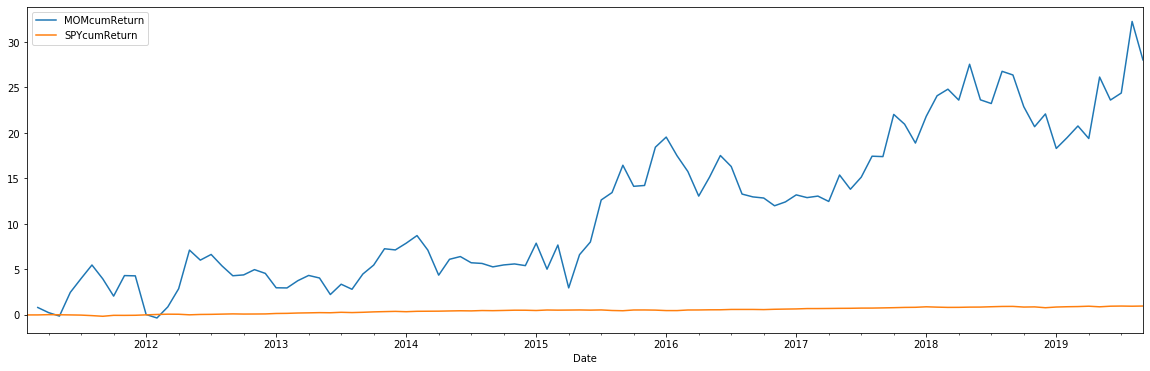

In [26]:
df_strategyReturns['MOMcumReturn'].plot(figsize = (20,6), legend = True)
spy['SPYcumReturn'].plot(figsize = (20,6), legend = True)

#### The momentum strategy massively outperformed the index during the time frame studied. It's worth mentioning that no transaction costs were included in the analysis, although I believe that the effect would not have changed the results considerably.